In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

In [2]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
#    import sobol_seq
import os
# from sklearn.preprocessing import MinMaxScaler

In [3]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [4]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than n_coll.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # Scale t
    scaler_t = MinMaxScaler()
    t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # Scale x
    scaler_x = MinMaxScaler()
    x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

In [5]:
def get_data_unif_coll(n_coll_t, n_coll_x, n_obs, seed, data_for_pinn = False):  
    '''
    n_coll_t (int) : Integer less than 101.
    n_coll_x (int) : Integer less than 256.
    n_obs (int)    : Integet less than n_coll_t x n_coll_x.
    seed (int)     : Seed to choose data point set.
    '''  
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten())
    # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = jnp.real(data['x'].flatten())
    # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = jnp.real(data['usol'])

    # Fine meshgrid
    T, X = jnp.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = jnp.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    lb, ub = X_star.min(0), X_star.max(0)    
    # Fine u values
    u_star = Exact.flatten()[:,None]
    triplets_fine = jnp.hstack([X_star,u_star])


    # Triples at collocation point set
    idx_t_all = jnp.round(jnp.linspace(0, len(t) - 1, n_coll_t)).astype(int)
    t_all = t[idx_t_all]
    idx_x_all = jnp.round(jnp.linspace(0, len(x) - 1, n_coll_x)).astype(int)
    x_all = x[idx_x_all]
    # Collocation meshgrid
    T_all, X_all = jnp.meshgrid(t_all,x_all)
    # Collocation_pairs
    tx_all = np.hstack((T_all.flatten()[:,None], X_all.flatten()[:,None]))

    def is_in_array2(coords, array2):
        # Compare each coordinate pair to all rows in array2 and return True if it matches any row
        return jnp.any(jnp.all(coords == array2, axis=1))
    check_inclusion = jax.vmap(lambda row: is_in_array2(row[:2], tx_all))

    coords_to_check = triplets_fine[:,:2]
    triplets_all = triplets_fine[check_inclusion(coords_to_check)]

    # Collocation point set
    tx_all = triplets_all[:,:2]

    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    triplets_train = triplets_obs[:int(N_obs*0.8),:]
    triplets_val = triplets_obs[int(N_obs*0.8):,:]

    # Data point set
    tx_train = triplets_train[:,:2]
    u_train = triplets_train[:,-1]

    # Validation point set
    tx_val = triplets_val[:,:2]
    u_val = triplets_val[:,-1]


    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])

    u_star = triplets_fine[:,-1]

    return tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star

We will compare `1.5 step` , `PINNSR` and  `SINDy` methods by using:

- Collocation point set: Randomly selected.
- Data point set: Randomly selected from Collocation point set.

by measuring the error of the recovered $u$ on the full given data.

We call the two functions `get_error_1_5` and `get_error_SINDy` in this notebook and later we upload the data resulting from `PINNSR` since they run on different Python environments.

In [6]:
def get_error_1_5(n_obs, n_coll_t,n_coll_x, run):
    
    tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star = get_data_unif_coll(n_coll_t=n_coll_t,n_coll_x=n_coll_x,n_obs = n_obs,seed=run)
    
    # # if using val
    # tx_obs = jnp.vstack([tx_train,tx_val])
    # u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

    # if not using val
    tx_obs = tx_train
    u_obs  = u_train   

    # Run 1_5 step method

    u_operators = (eval_k,)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    
    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    # print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
        .reshape(
                len(tx_all),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)    
        
    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_all,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 100
    )

    # Optimize - LM
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    params,convergence_data = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        max_iter = 501,
        init_alpha=0.1,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,10)
    # u_params
    u_sol = p_adjusted[:u_model.num_params]
    # u_true 
    u_true = u_star.flatten()
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))
    
    return error_u_field

In [7]:
def get_error_SINDy(n_obs, n_coll_t, n_coll_x, run):
    tx_train, u_train, tx_val, u_val, tx_all, _, _, u_star, X_star = get_data_unif_coll(n_coll_t=n_coll_t,n_coll_x=n_coll_x,n_obs = n_obs,seed=run)
    
    # # if using val
    # tx_obs = jnp.vstack([tx_train,tx_val])
    # u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

    # if not using val
    tx_obs = tx_train
    u_obs  = u_train

    # Run SINDy method

    u_operators = (eval_k,)
    feature_operators = (eval_k,dt_k,dx_k,dxx_k)

    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)

    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

    # print(1/(jnp.sqrt(ML_lengthscales)))

    u_model = CholInducedRKHS(
        tx_obs,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )

    u_params = u_model.get_fitted_params(tx_obs,u_obs)

    # S = (
    #     (u_model.evaluate_operators(feature_operators,tx_all,u_params))
    #     .reshape(
    #             len(tx_all), 
    #             len(feature_operators),
    #             order = 'F'
    #         )
    # )

    # U_t = S[:,1]
    # UU_x = jnp.multiply(S[:,0],S[:,2])
    # U_xx = S[:,3]

    # Theta = jnp.vstack([UU_x, U_xx]).T
    
    # res = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)
    #print(f'SINDy recovered equation: u_t = {round(res[0][0],4)}uu_x + {round(res[1][0],4)}u_xx')
    
    # u_true 
    u_true = u_star.flatten()
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_params))
    
    return error_u_field

In [8]:
err = {
    '1_5_mthd': [],
    'SINDy':   []
}

In [ ]:
# Run loop
NUM_RUNS = 5
N_OBS = [int(i) for i in jnp.arange(20,110,10)]
for n_obs in N_OBS:
    u_error_1_5 = []
    u_error_SINDy = []
    for run in range(NUM_RUNS):
        # Run
        res_1_5 = get_error_1_5(n_obs = n_obs,n_coll_t=31,n_coll_x=26,run=run)
        res_SINDy = get_error_SINDy(n_obs = n_obs,n_coll_t=31,n_coll_x=26,run=run)
        # Append
        u_error_1_5.append(res_1_5)
        u_error_SINDy.append(res_SINDy)
    # Append each list    
    err['1_5_mthd'].append(u_error_1_5)
    err['SINDy'].append(u_error_SINDy)   
    # Save after
    jnp.save('errors_comparisons/err_1_5_w_SINDy', err)

In [10]:
err = jnp.load('errors_comparisons/err_1_5_w_SINDy.npy', allow_pickle=True).item()

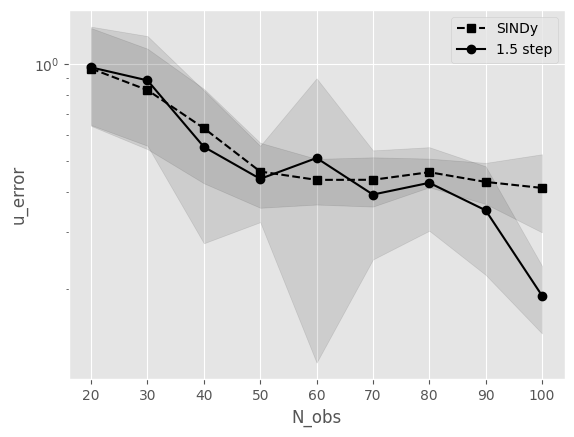

In [13]:
# Collocation points errors plot
# plt.title('Error vs. N | Burgers')
# Colors
c2 = 'black'
c1 = 'black'
# SINDy method plot
mean_SINDy = jnp.array([jnp.mean(e) for e in jnp.array(err['SINDy'])])
sd_SINDy = jnp.array([jnp.std(e) for e in jnp.array(err['SINDy'])])
# Plot 2 method
plt.plot(N_OBS, mean_SINDy, label = f'SINDy', marker= 's', color = c2,linestyle = 'dashed')
plt.fill_between(N_OBS, mean_SINDy - sd_SINDy, mean_SINDy + sd_SINDy, alpha=.1, color = c2)
plt.yscale('log')
# 1_5 step method plot

# 1_5 method
mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'])])
sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'])])
# Plot 1_5 method
plt.plot(N_OBS, mean_i_opt_1_5, label =  f'1.5 step', marker= 'o', color = c1)
plt.fill_between(N_OBS, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
plt.yscale('log')

plt.legend(loc = 'upper right')

plt.ylabel('u_error')
plt.xlabel('N_obs')
# # adding labels to the plotlines
# xvals_2step = [5]*4 + [7.5]
# xvals_1step = [6.5]+[7]*4
# xvals = xvals_2step + xvals_1step
# lines = plt.gca().get_lines()
# labelLines(lines, align=True, xvals = xvals)
# # add legend box
# legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
#                    Line2D([0], [0], color= c1, label='1.5-step')]
# plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()